# EcoFOCIpy ADCP QC - 22BSP-5A

- mostly remove >100 cm/s flows in u/v


In [1]:
import xarray as xa
import numpy as np

import matplotlib.pyplot as plt

from EcoFOCIpy.plots import TimeSeriesStickPlot

In [2]:
xdf = xa.load_dataset('22bsp4a_0058m.nc')

/Users/bell/src/ecofocipy/src/EcoFOCIpy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
/Users/bell/src/ecofocipy/src/EcoFOCIpy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
/Users/bell/src/ecofocipy/src/EcoFOCIpy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
/Users/bell/src/ecofocipy/src/EcoFOCIpy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
/Users/bell/src/ecofocipy/src/EcoFOCIpy/plots/TimeSeriesStickPlot.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabe

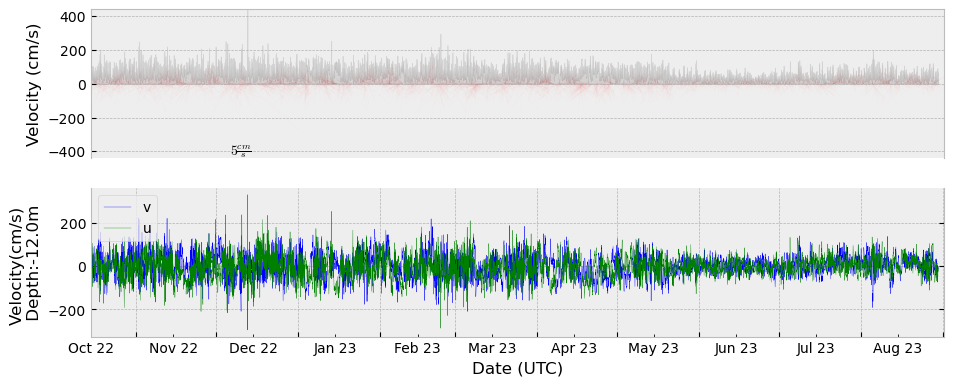

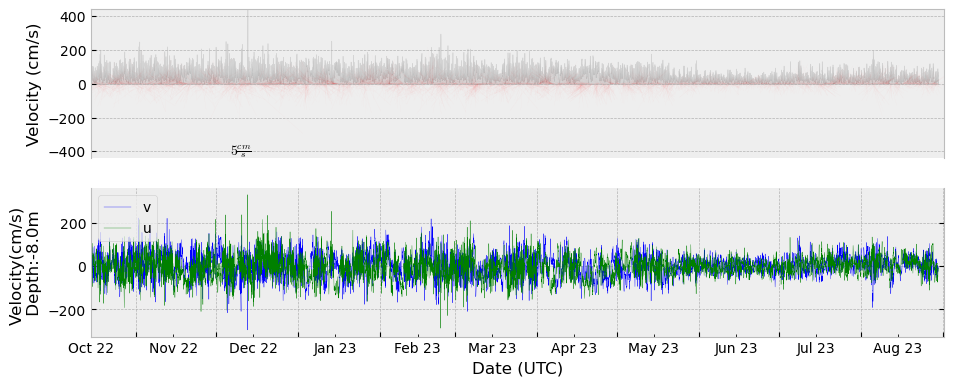

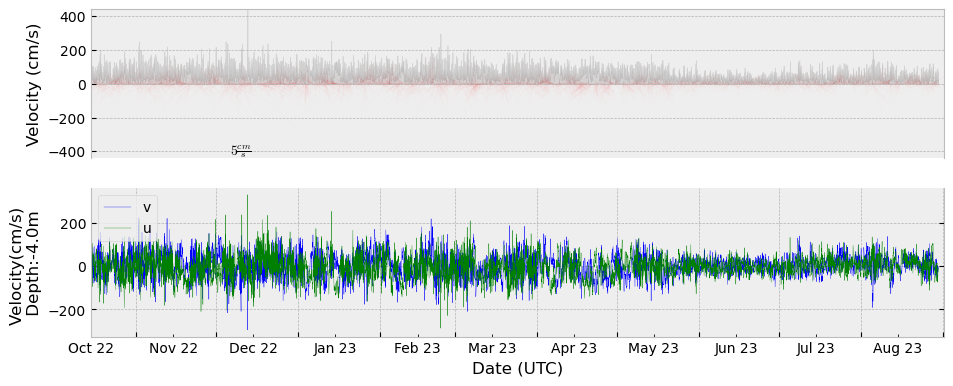

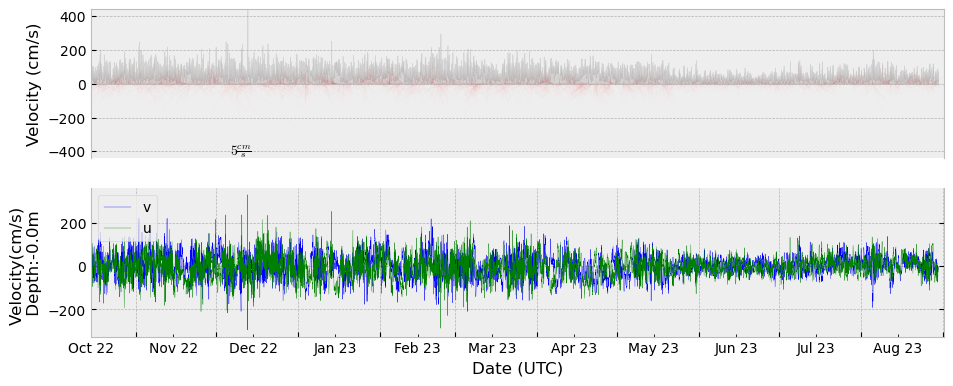

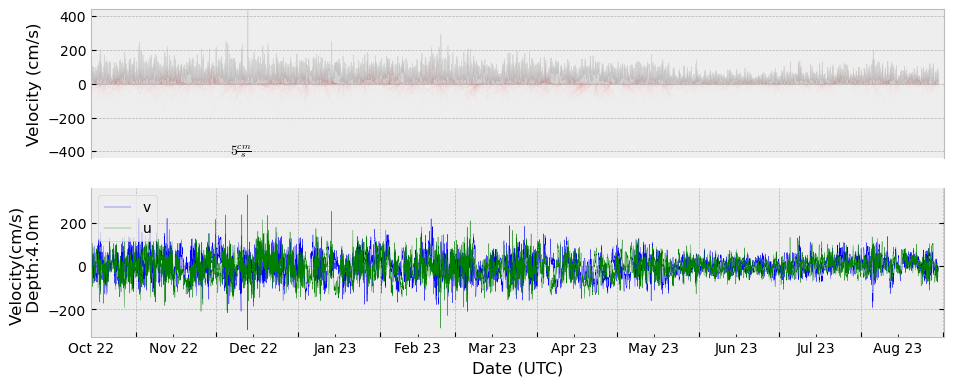

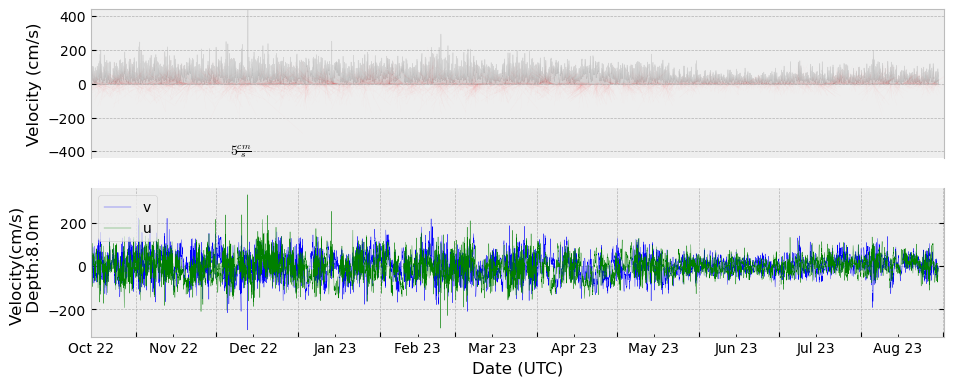

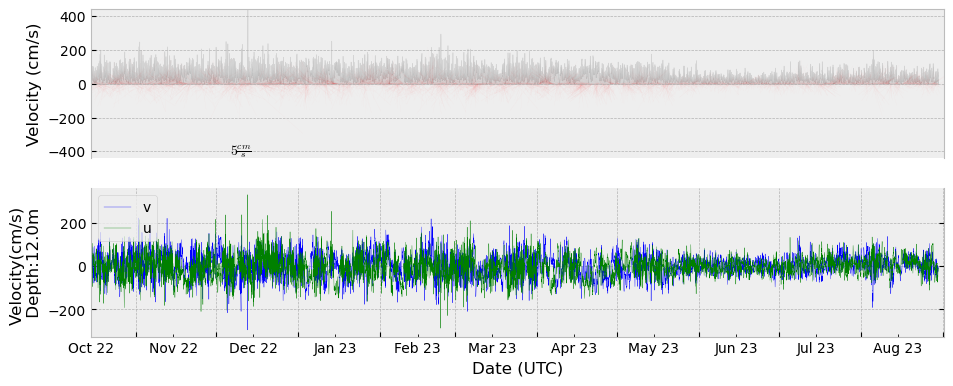

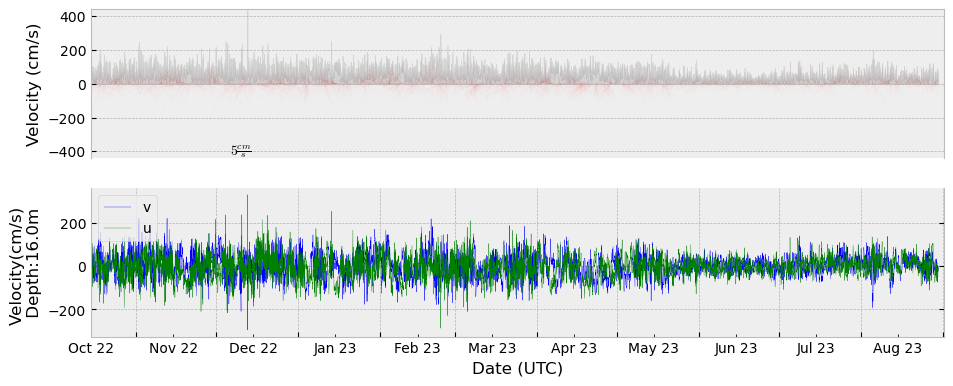

In [5]:
for i in range(0,len(xdf),1):
    try:
        p1 = TimeSeriesStickPlot.Timeseries1dStickPlot()
        plt1, fig1 = p1.plot(timedata=xdf.time, 
                         udata=xdf.isel(depth=1,latitude=0,longitude=0).u_curr_comp, 
                         vdata=xdf.isel(depth=1,latitude=0,longitude=0).v_curr_comp,
                         rotate=0,
                         ylabel = f'Velocity(cm/s) \n {xdf.isel(depth=i).depth.values}m ')
        plt1.ylabel(f'Velocity(cm/s) \n Depth:{xdf.isel(depth=i).depth.values}m ')
    except:
        pass

## BAsed on above plots - choose a relavant cutoff velocity (usually 100 or 500 cm/s)

In [6]:
xdf =xdf.where(xdf.u_curr_comp <=1000,np.nan)
xdf

<xarray.Dataset>
Dimensions:          (latitude: 1, longitude: 1, time: 7708, depth: 17)
Coordinates:
  * time             (time) datetime64[ns] 2022-10-15 ... 2023-09-01T02:59:59
  * depth            (depth) float64 -12.0 -8.0 -4.0 -0.0 ... 44.0 48.0 52.0
  * latitude         (latitude) float64 57.87
  * longitude        (longitude) float64 -168.9
Data variables:
    u_curr_comp      (latitude, longitude, time, depth) float64 16.61 ... nan
    v_curr_comp      (latitude, longitude, time, depth) float64 -16.81 ... nan
    w_curr_comp      (latitude, longitude, time, depth) float64 9.9 ... nan
    w_curr_comp_err  (latitude, longitude, time, depth) float64 14.9 ... nan
    agc1             (latitude, longitude, time, depth) float64 96.0 ... nan
    agc2             (latitude, longitude, time, depth) float64 94.0 ... nan
    agc3             (latitude, longitude, time, depth) float64 96.0 ... nan
    agc4             (latitude, longitude, time, depth) float64 94.0 ... nan
Attributes:
    Latitude_DegMMddW:                      57 52.071 N
    Longitude_DegMMddN:                     168 53.379 W
    MooringID:                              22BSP-4A
    platform_deployment_date:               2022-09-05T19:45:00Z
    platform_deployment_cruise_name:        AQ2201
    platform_recovery_date:                 2023-08-30T02:13:00Z
    platform_recovery_cruise_name:          AQ2301
    platform_deployment_recovery_comments:  
    WaterDepth:                             73.5
    date_created:                           2024-04-15T08:24:06Z
    date_modified:                          
    QC_indicator:                           unknown

In [7]:
# xdf['history'] = xdf.history + 'QC of high u/v values'

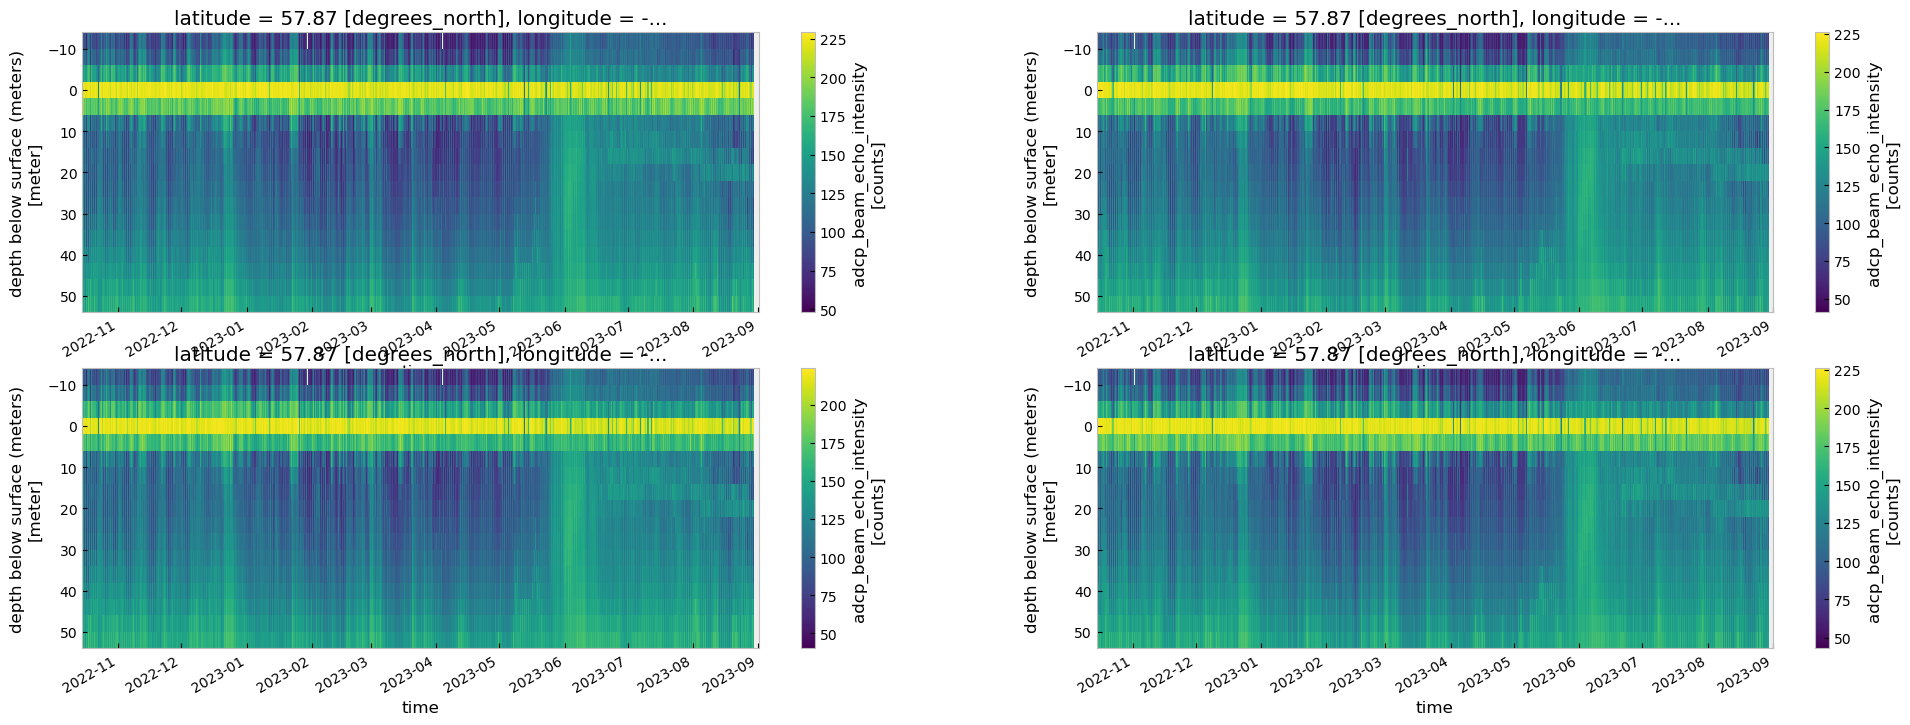

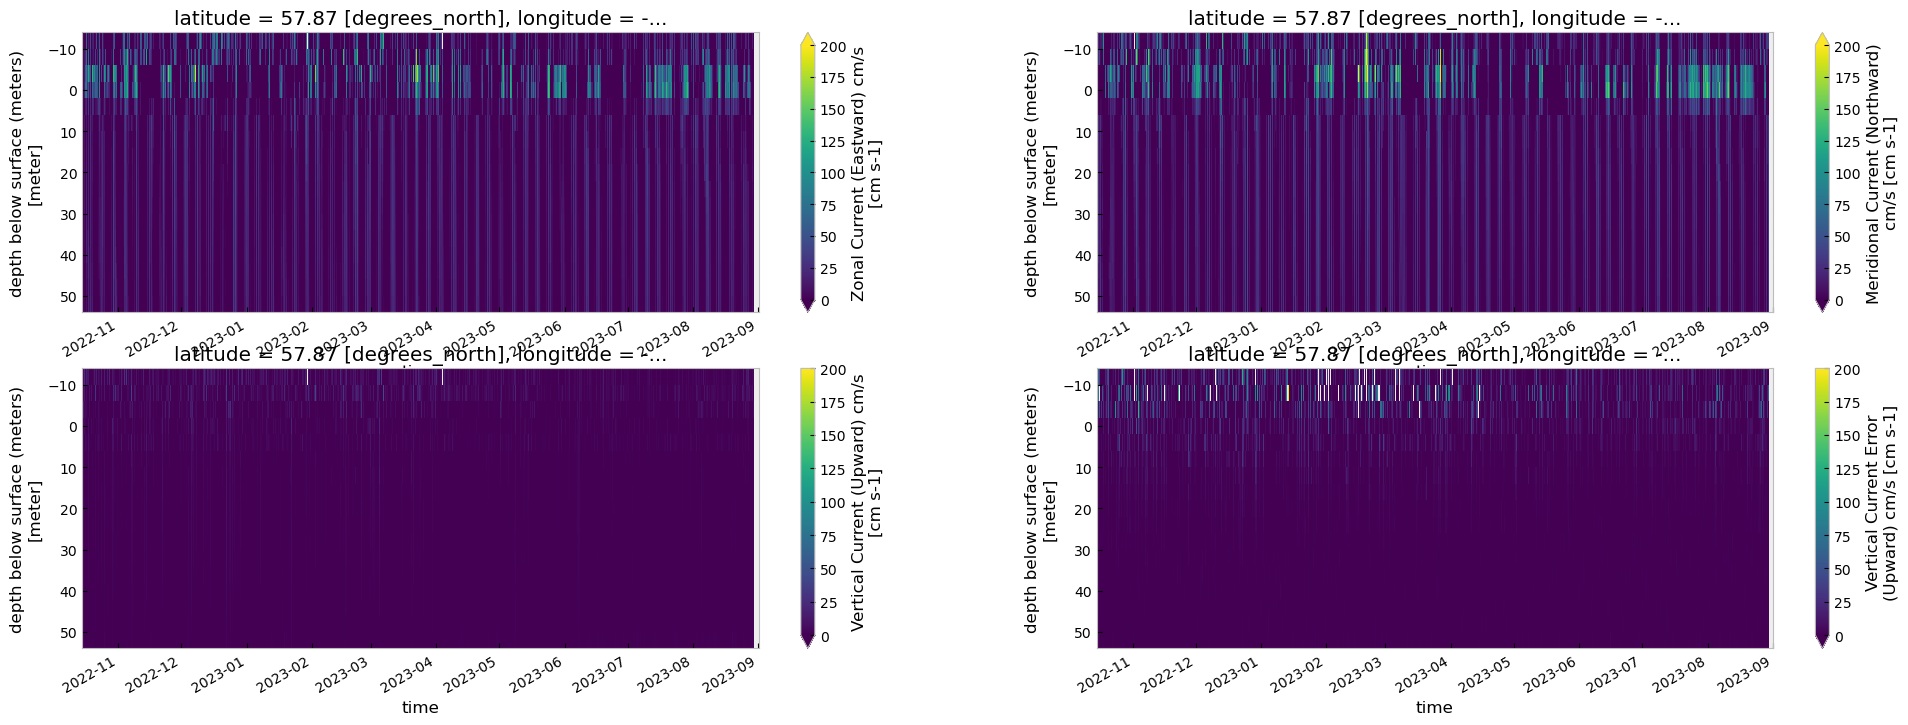

In [8]:
#optional plotting

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    xdf['agc1'].T.plot(ax=axes[0,0], yincrease=False)
    xdf['agc2'].T.plot(ax=axes[0,1], yincrease=False)
    xdf['agc3'].T.plot(ax=axes[1,0], yincrease=False)
    xdf['agc4'].T.plot(ax=axes[1,1], yincrease=False)
except:
    pass

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    xdf['u_curr_comp'].T.plot(ax=axes[0,0],vmin=0, vmax=200, yincrease=False)
    xdf['v_curr_comp'].T.plot(ax=axes[0,1],vmin=0, vmax=200, yincrease=False)
    xdf['w_curr_comp'].T.plot(ax=axes[1,0],vmin=0, vmax=200, yincrease=False)
    xdf['w_curr_comp_err'].T.plot(ax=axes[1,1],vmin=0, vmax=200, yincrease=False)
except:
    pass

In [9]:
try:
    xdf.attrs['history'] = xdf.attrs['history']+'  removed U,V >1000cm/s'
except:
    xdf.attrs['history'] = '  removed U,V >1000cm/s'    

## Trim above surface (negative values)

In [10]:
ixdf = xdf.where(xdf.depth >=-0.).dropna(how='all',dim='depth')

In [11]:
ixdf.attrs['history'] = ixdf.attrs['history']+'  trimmed above surface'

In [12]:
ixdf.to_netcdf('22bsp4a_0058m.trimmed.nc')

In [13]:
xdf = xa.load_dataset('22bsp4a_0058m.trimmed.nc')

In [14]:
ixdf = xdf.interpolate_na(dim='time',use_coordinate=True,max_gap='2H')

In [15]:
ixdf.attrs['history'] = ixdf.attrs['history']+'  linearly interpolated 1hour gaps'

In [16]:
ixdf = ixdf.interpolate_na(dim='depth',max_gap=3)

In [17]:
ixdf.attrs['history'] = ixdf.attrs['history']+'  linearly interpolated 2 vertical bin'

## Interpolate over singleton missing gaps linearly

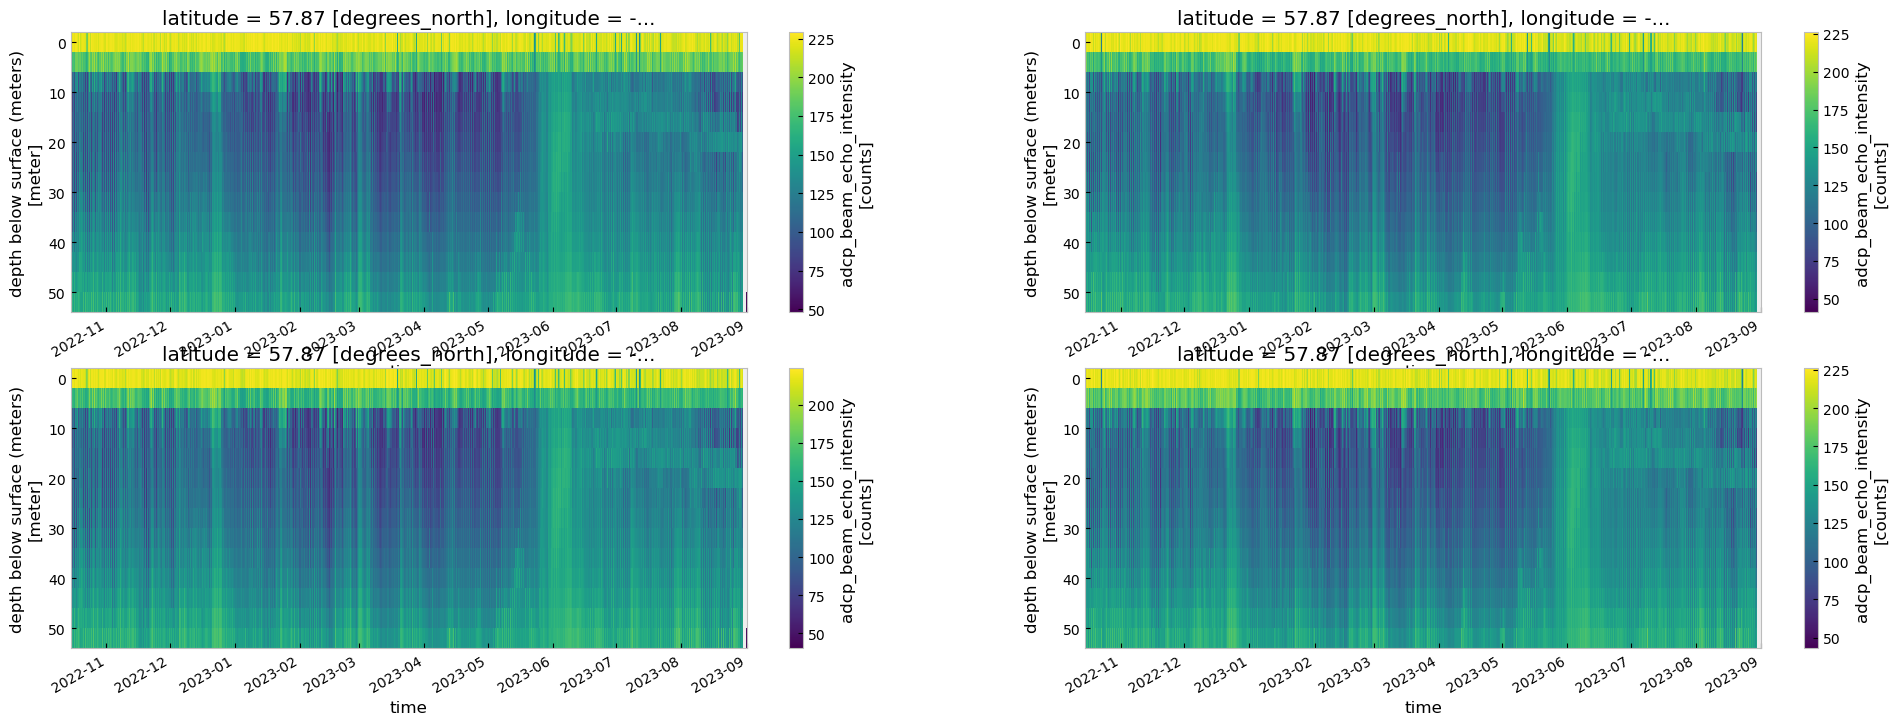

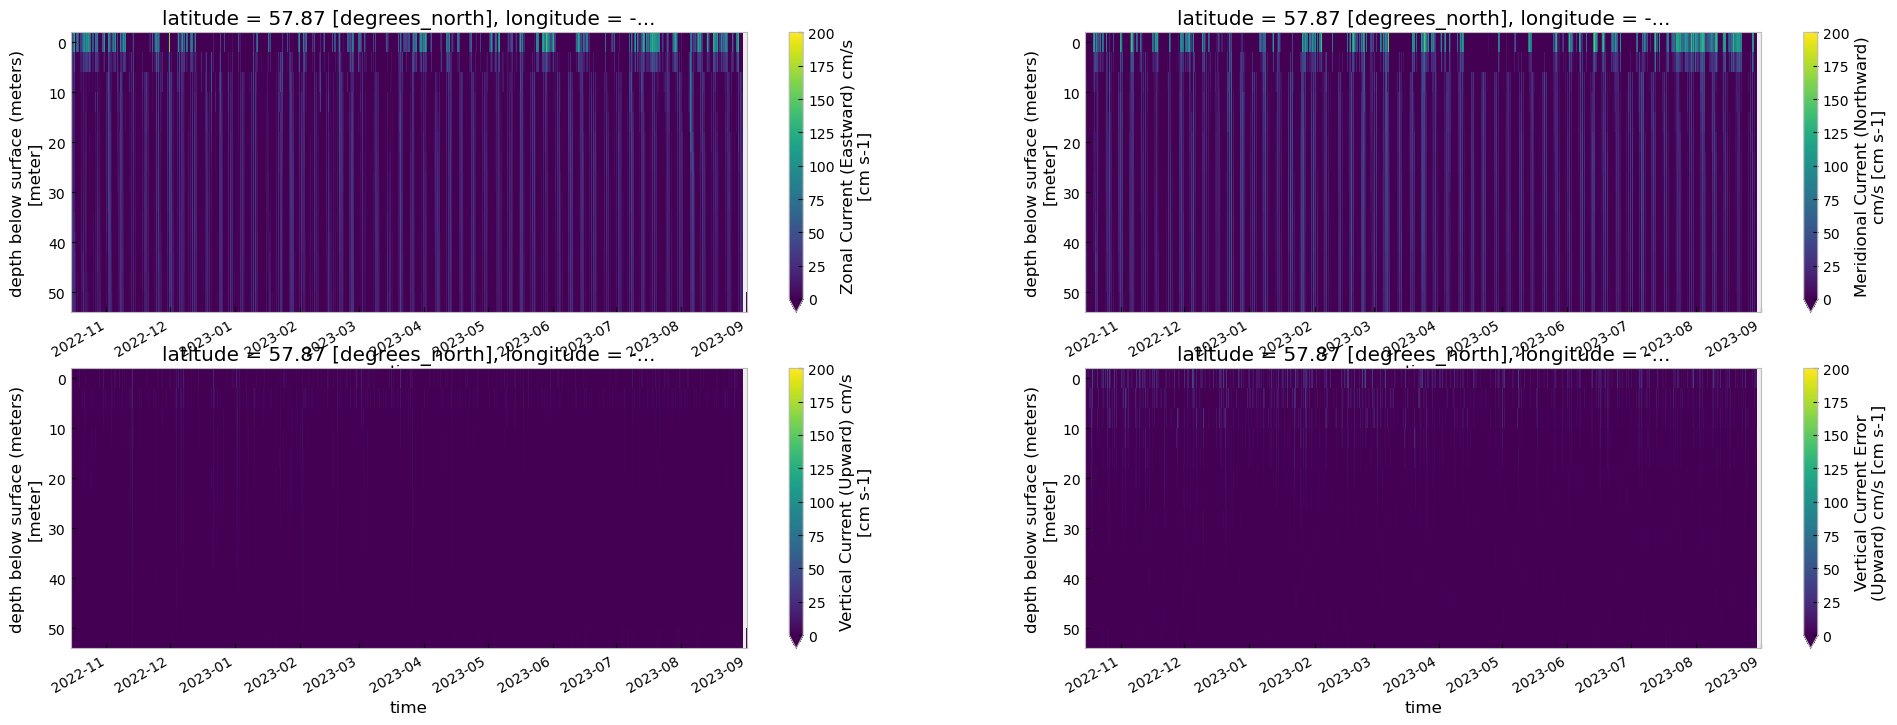

In [18]:

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    ixdf['agc1'].T.plot(ax=axes[0,0], yincrease=False)
    ixdf['agc2'].T.plot(ax=axes[0,1], yincrease=False)
    ixdf['agc3'].T.plot(ax=axes[1,0], yincrease=False)
    ixdf['agc4'].T.plot(ax=axes[1,1], yincrease=False)
except:
    pass

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    ixdf['u_curr_comp'].T.plot(ax=axes[0,0],vmin=0, vmax=200, yincrease=False)
    ixdf['v_curr_comp'].T.plot(ax=axes[0,1],vmin=0, vmax=200, yincrease=False)
    ixdf['w_curr_comp'].T.plot(ax=axes[1,0],vmin=0, vmax=200, yincrease=False)
    ixdf['w_curr_comp_err'].T.plot(ax=axes[1,1],vmin=0, vmax=200, yincrease=False)
except:
    pass

In [19]:
ixdf.to_netcdf('22bsp4a_0058m.filtered.nc')